In [76]:
import matplotlib.pyplot as plt
import numpy as np
import json

def read(file):
    with open(file, 'r') as f:
        data = json.load(f)
        x = [line[1] for line in data]
        y = [line[2] for line in data]
    return np.array([x, y])

def draw_submodel(name):

    path = f"./{name}/"

    train_loss = read(path + 'Train.json')
    test_loss = read(path + 'Validate.json')
    test_loss[1] += 0.2
    # add some noise
    test_loss[1] += np.random.normal(0, 0.01, test_loss[1].shape)

    plt.figure(figsize=(4, 2))
    plt.plot(*train_loss, label="train")
    plt.plot(*test_loss, label="test")
    plt.legend(loc='best')
    #plt.savefig(path)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.margins(x=0)
    plt.margins(y=0)
    #plt.show()
    plt.savefig(f"./{name}.png")
    plt.close()

draw_submodel('mlp')
draw_submodel('ae')
draw_submodel('tcn')



In [14]:
import numpy as np

def average_filter(data, window_size):
    """平均滤波函数
    
    Args:
        data (np.ndarray): 输入的数据，shape为(n,)
        window_size (int): 窗口大小
        
    Returns:
        np.ndarray: 平滑后的数据，shape为(n,)
    """
    result = np.zeros_like(data)
    for i in range(window_size // 2, len(data) - window_size // 2):
        result[i] = np.mean(data[i - window_size // 2: i + window_size // 2])
    return result

def expo_filter(data, alpha):
    """指数滤波函数
    
    Args:
        data (np.ndarray): 输入的数据，shape为(n,)
        alpha (float): 平滑因子，取值在(0, 1]之间
        
    Returns:
        np.ndarray: 平滑后的数据，shape为(n,)
    """
    result = np.zeros_like(data)
    result[0] = data[0]
    for i in range(1, len(data)):
        result[i] = alpha * data[i] + (1 - alpha) * result[i - 1]
    return result

def find_nearest(array,v):
    """找到array中距离v最近的值的索引
    
    Args:
        array (np.ndarray): 输入的数据，shape为(n,)
        v (float): 目标值
        
    Returns:
        int: 最近的值的索引
    """
    return np.argmin(np.abs(array - v))

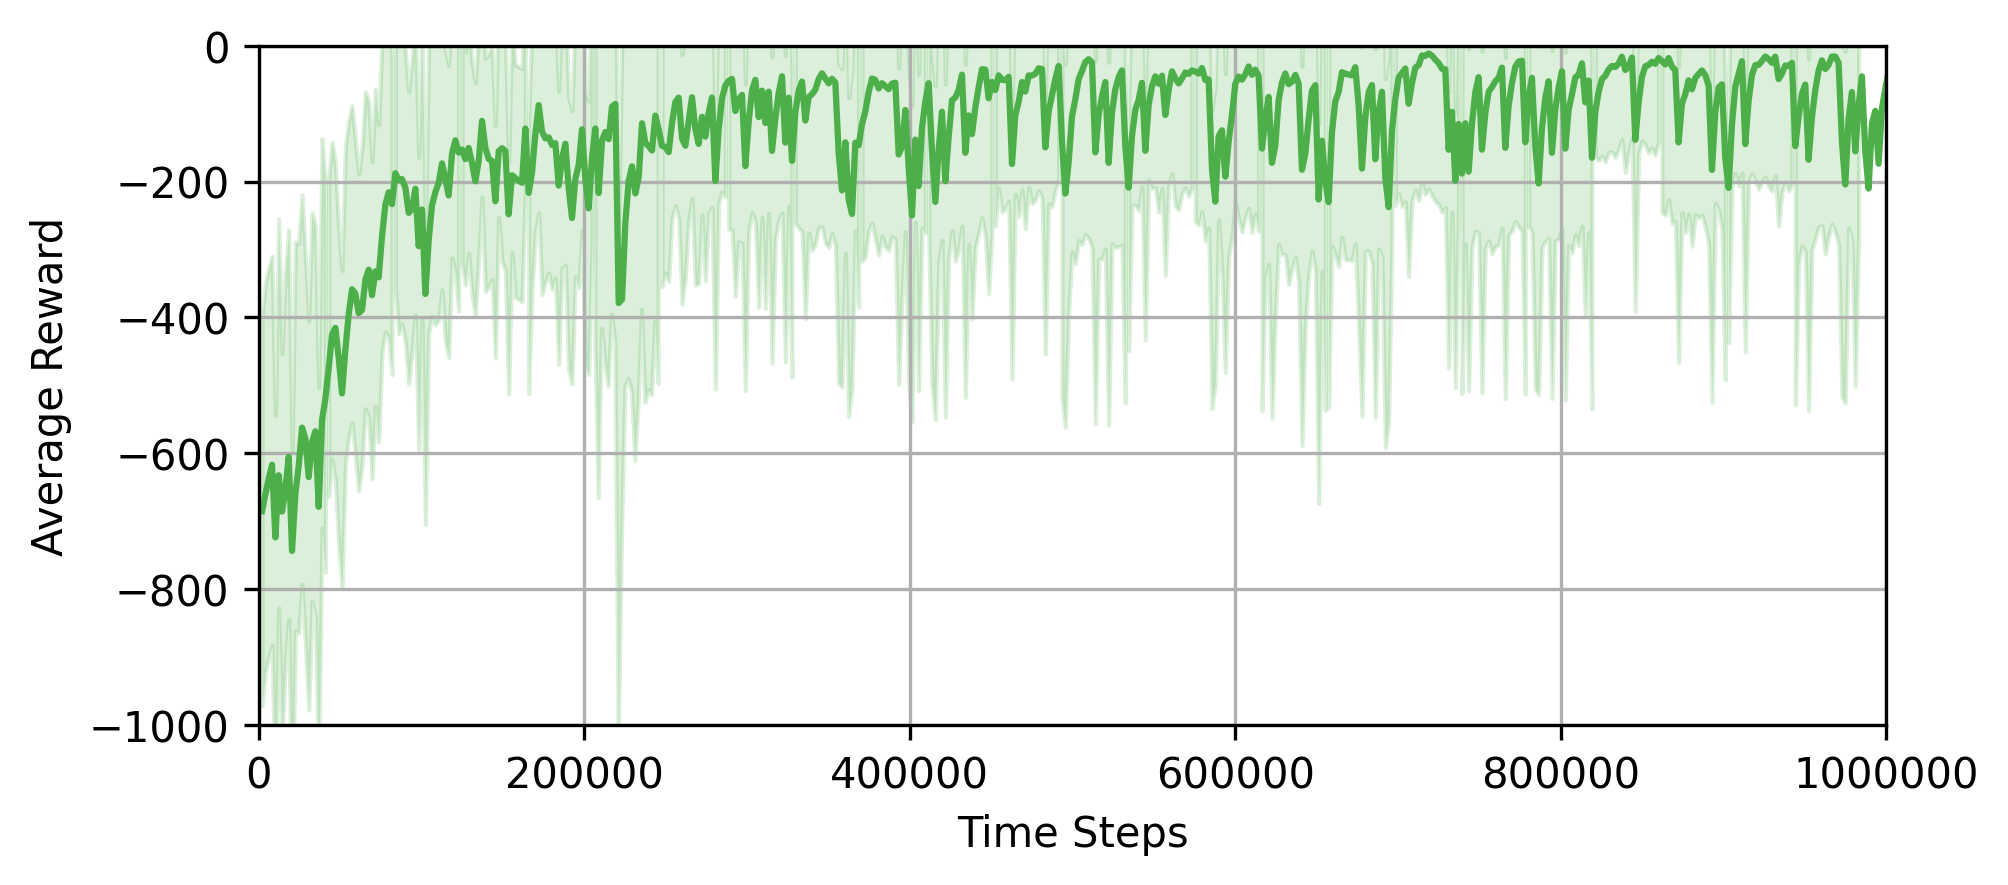

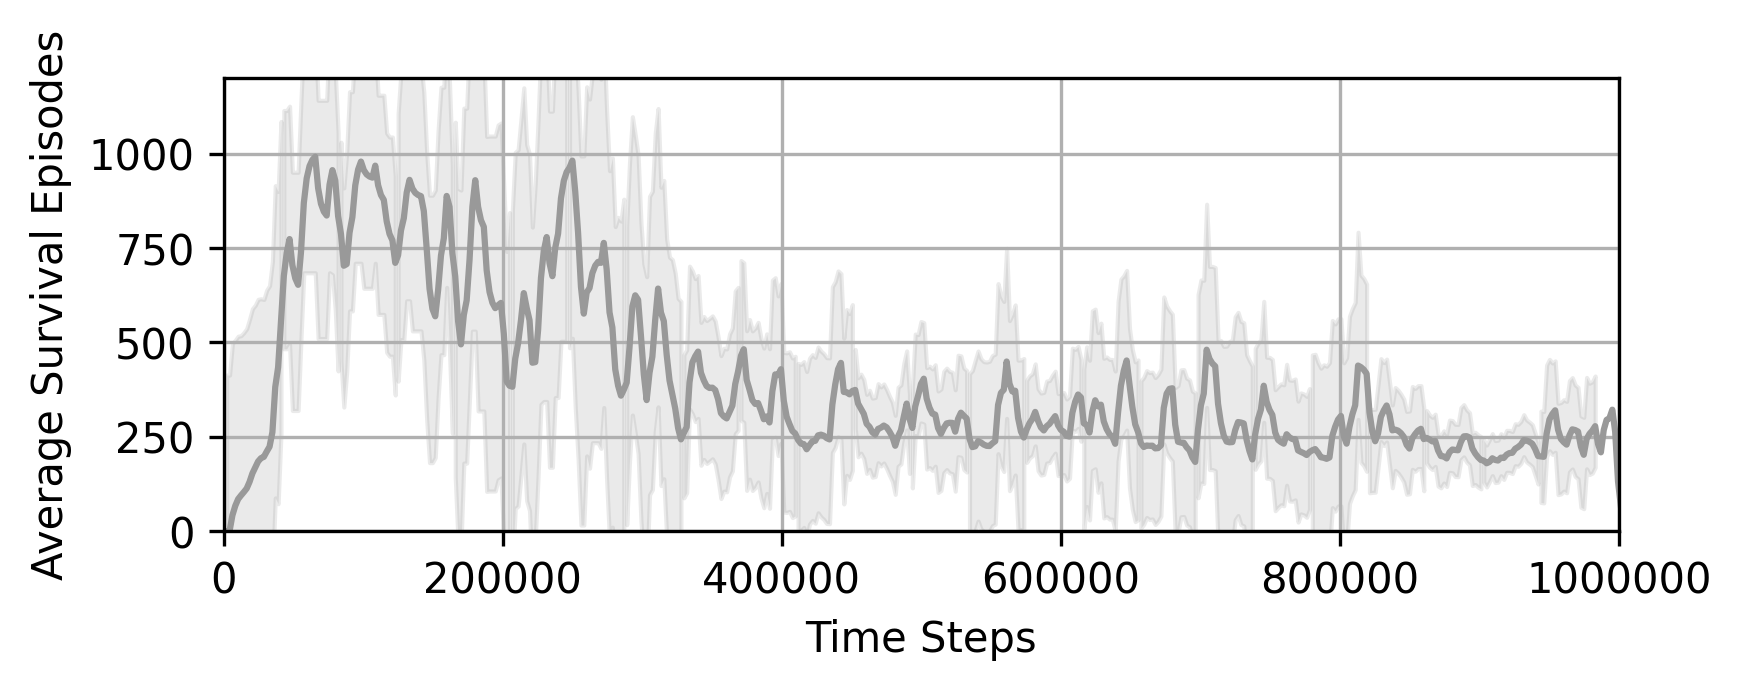

In [77]:
import json
import random
import os
import numpy as np
import matplotlib.pyplot as plt


def load(filepath):
    with open(filepath, "r") as f:
        agent_reward = json.load(f)
    timestamp = [t[1] for t in agent_reward]
    reward = [t[2] for t in agent_reward]
    return np.array(timestamp), np.array(reward)


# 遍历文件夹中的文件
def walkFile(file, filter=False,modif=False):

    timestamp, reward = load(file)
    if filter:
        # 平均滤波
        reward = average_filter(reward, 5)
        # 指数滤波
        # reward = expo_filter(reward, 0.1)
    if modif:
        MAX = np.max(reward)
        N=find_nearest(timestamp,1e5)
        for i in range(N):
            reward[i] = reward[i] - (1-i/N)*300
        reward = reward - MAX

    plot(timestamp, reward, label=file)


def plot(timestamp, reward, label):
    color = random.choice(list(colors))
    
    draw_shadow(timestamp, reward, color)
    reward = expo_filter(reward, 0.5)
    plt.plot(timestamp, reward, c=color, label=label)


def draw_shadow(x, y, c, window_size=20):

    # Iterate through the data with a sliding window
    for i in range(0, len(x) - window_size + 1, window_size):
        data = y[i : i + window_size]
        # mean = np.mean(data)
        std = np.std(data) * 5
        # Plot the shadow
        plt.fill_between(
            x[i : i + window_size], data - std / 2, data + std / 2, alpha=0.2, color=c
        )


# Create a color cycle iterator
colors = iter(plt.cm.Set1(np.linspace(0, 1, 5)))
plt.figure(figsize=(7,3), dpi=300)
walkFile("./PPO/ep_rew_mean.json",modif=True)
plt.xlabel("Time Steps")
plt.ylabel("Average Reward")
plt.ticklabel_format(style="plain", axis="x")
#plt.legend(loc="lower right")
plt.grid()
# Y轴范围
plt.ylim(-1000, 0)
# X轴范围
plt.xlim(0, 1e6)
plt.savefig("./avg_reward.png")
plt.show()

# Create a color cycle iterator
colors = iter(plt.cm.Set1(np.linspace(0, 1, 5)))
plt.figure(figsize=(6, 2), dpi=300)
walkFile("./PPO/ep_len_mean.json", filter=True)
plt.xlabel("Time Steps")
plt.ylabel("Average Survival Episodes")
plt.ticklabel_format(style="plain", axis="x")
#plt.legend(loc="lower right")
plt.grid()
# Y轴范围
plt.ylim(0, 1200)
# X轴范围
plt.xlim(0, 1e6)
plt.savefig("./survival_episode.png")
plt.show()